# Timing Resolution

* Utilize pre-trained NF model to sample timings
* Calculate timing resolution of sampled timings
* Calculate timing resolution of optical photon hit times
* Compare std and mean of first hit timing distribution

## Setup
**Package imports:**

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from IPython.display import clear_output
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.ticker as plticker
import os
from typing import Union, List
from scipy.stats import norm

**local imports (written by me):**

In [2]:
from reco import process_data, create_dataloader, prepare_data_for_nn, create_dataloader,\
    create_unique_mapping,calculate_num_pixels_z_dependence,process_data_one_segment,\
    prepare_data_for_nn_one_segment
from util import PVect, theta_func, r_func,get_layer, create_layer_map,load_real_data,time_func,p_func

from time_res_util import process_times,get_all_times,checkdir

Using device cuda:0


### Set parameters of model and data

In [3]:
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")

## Neural Spline Flow
model definition:

Create directories / pick where to pull from

#### Optph: process times and get distribution

In [4]:
from time_res_util import avg_time
def process_times(uproot_path,threshold = 10, multipleFiles = False):
    if(multipleFiles):
        times_arrays_list = []
        cells_arrays_list = []
        x_pos_arrays_list = []
        y_pos_arrays_list = []
        z_pos_arrays_list = []
        px_arrays_list = []
        py_arrays_list = []
        pz_arrays_list = []
        m_arrays_list = []

        # Loop through all files in the directory
        for file_name in os.listdir(uproot_path):
            if file_name.endswith(".root"):  # Ensure we're only processing ROOT files
                file_path = os.path.join(uproot_path, file_name)

                # Open the ROOT file
                with up.open(file_path) as file:
                    # Open tree
                    tree = file["events"]

                    times_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.time"].array(library="np"))
                    cells_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.cellID"].array(library="np"))
                    x_pos_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.position.x"].array(library="np"))
                    y_pos_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.position.y"].array(library="np"))
                    z_pos_arrays_list.append(tree["HcalBarrelHits/HcalBarrelHits.position.z"].array(library="np"))
                    
                    px_arrays_list.append(tree["MCParticles/MCParticles.momentum.x"].array(library="np"))
                    py_arrays_list.append(tree["MCParticles/MCParticles.momentum.y"].array(library="np"))
                    pz_arrays_list.append(tree["MCParticles/MCParticles.momentum.z"].array(library="np"))
                    
                    m_arrays_list.append(tree["MCParticles/MCParticles.mass"].array(library="np"))

        # Combine arrays for each branch
        times = np.concatenate(times_arrays_list)
        cells = np.concatenate(cells_arrays_list)
        x_pos_branch = np.concatenate(x_pos_arrays_list)
        y_pos_branch = np.concatenate(y_pos_arrays_list)
        z_paugust_7_theta_90_pos_0_0_middle_z_calos_branch = np.concatenate(z_pos_arrays_list)
        
        px_branch = np.concatenate(px_arrays_list)
        py_branch = np.concatenate(py_arrays_list)
        pz_branch = np.concatenate(pz_arrays_list)
        
        m_branch = np.concatenate(m_arrays_list)

        # Now combined_arrays contains the concatenated arrays for each branch across all files
    else:
        events = up.open(uproot_path)

        times = events["HcalBarrelHits/HcalBarrelHits.time"].array(library='np')
        cells = events["HcalBarrelHits/HcalBarrelHits.cellID"].array(library='np')
        x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
        y_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.y"].array(library='np')
        z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
        
        px_branch = events["MCParticles/MCParticles.momentum.x"].array(library='np')
        py_branch = events["MCParticles/MCParticles.momentum.y"].array(library='np')
        pz_branch = events["MCParticles/MCParticles.momentum.z"].array(library='np')
        
        m_branch = events["MCParticles/MCParticles.mass"].array(library='np')
        
    accepted_times = []
    second_lowest_list = []
    avg_accepted_times = []
    rel_accepted_times = []

    duplicates = 0
    total = 0
    total_cells = []

    skipped = 0
    num_list = []
    
    
    #First loop over events
    for event_num in range(len(cells)):

        #skip events with less than 2 photons
    #     if(times[event_num].shape[0] < threshold): continue

        #Keep track of which cell IDs are hit
        curr_list = []
        for photon_num in range(len(cells[event_num])):
            if(cells[event_num][photon_num] in curr_list):
                duplicates += 1
            else:
                curr_list.append(cells[event_num][photon_num])
            if(cells[event_num][photon_num] not in total_cells):
                total_cells.append(cells[event_num][photon_num])
            total += 1
            
        curr_p = p_func(px_branch[event_num][0],py_branch[event_num][0],pz_branch[event_num][0])#muon momentum
        curr_travel_time = time_func(curr_p,m_branch[event_num][0],1769.3) #maybe 1770.3
        event_adjusted_times = times[event_num] - curr_travel_time
        
        num_list.append(len(curr_list))
        #check if 2 unique pixels are hit
        if(len(curr_list) < threshold): 
            skipped += 1
            continue
        curr_min = min(event_adjusted_times)
        accepted_times.append(curr_min)
        second_lowest_list.append(min([x for x in event_adjusted_times if x != curr_min]))
        avg_accepted_times.append(avg_time(threshold,event_adjusted_times))
    #     if(len(curr_list) == 15):
    #         print(f"event #{event_num}")
    print(f"total: {total} | duplicates: {duplicates} | ratio: {duplicates / total} | num unique cells hit: {len(total_cells)} | skipped: {skipped}")
    return accepted_times, second_lowest_list, avg_accepted_times

In [8]:
#Minimum number of pixels to be hit for us to accept event
threshold = 10


# uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/September_12/run_1"

# Most up-to-date data from 1cm thick w QE
# uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/January_25/"

# Most up-to-date data from 1cm thick without QE
#uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/January_25/no_QE"

# Most up-to-date data from 2cm thick without QE
# uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/January_27/run_1_without_QE_2cm_thickness/"

# Most up-to-date data from 2cm thick w QE
uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/January_27/run_1_w_QE_2cm_thickness/"

accepted_times, second_lowest_list, avg_accepted_times = process_times(uproot_path, threshold,True)

total: 876688 | duplicates: 57574 | ratio: 0.06567216615261073 | num unique cells hit: 6532 | skipped: 1


In [9]:
#timing resolution:
accepted_times = np.array(accepted_times)

cut_accepted_times = accepted_times[accepted_times < 4.9]
cut_accepted_times = cut_accepted_times[cut_accepted_times > 4.2]


(mu_real, sigma_real) = norm.fit(accepted_times)
(mu_real_cut, sigma_real_cut) = norm.fit(cut_accepted_times)
print("\tsigma:\t\t| mean:\t\t")
print("Real:\t\t  %4.3f |\t %4.2f" %(sigma_real,mu_real))
print("Real cut:\t\t  %4.3f |\t %4.2f" %(sigma_real_cut,mu_real_cut))

	sigma:		| mean:		
Real:		  0.125 |	 4.53
Real cut:		  0.110 |	 4.54


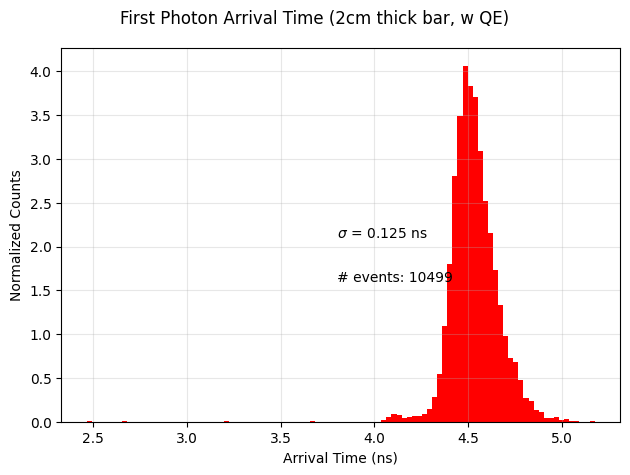

In [10]:
fig_first_times, axs_first_times = plot.subplots(1,1)
axs_first_times.hist(accepted_times,bins = 100,alpha = 1, color = "red",density = True);
# axs_first_times.legend()
axs_first_times.set_ylabel("Normalized Counts")
axs_first_times.set_xlabel("Arrival Time (ns)")
axs_first_times.text(3.8,2.1,r"$\sigma$ = %.3f ns" % (sigma_real))
axs_first_times.text(3.8,1.6,r"# events: %d" % (len(accepted_times)))
axs_first_times.grid(alpha = 0.3)
fig_first_times.suptitle("First Photon Arrival Time (2cm thick bar, w QE)")
fig_first_times.tight_layout()
plot.show()
fig_first_times.savefig("plots/time_res/January_25/time_res_10GeV_mu_w_QE_2cm.pdf")